In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



In [272]:
def plot_model_performance_graph(hist_df):
    
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)

    ax = axes[0]

    hist_df.plot(y = ['loss','val_loss'], ax = ax, colormap="cividis")

    lossmin = hist_df['loss'].min()

    testmin = hist_df['val_loss'].min()

    # little beautification
    txtstr = "Min Loss: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(lossmin,
                                                                            testmin) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")

    ax.set_ylabel("Loss")

    ax.grid();

    ax = axes[1]

    hist_df.plot( y = ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy'], ax = ax, colormap="cividis")
    acc = hist_df['sparse_categorical_accuracy'].values
    # little beautification
    accmax = hist_df['sparse_categorical_accuracy'].max()
    testmax = hist_df['val_sparse_categorical_accuracy'].max()
    txtstr = "Max Accuracy: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(accmax,
                                                                                testmax) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.5, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.grid();
    plt.tight_layout()

In [2]:
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 37.0 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 28.0 MB/s 
     |████████████████████████████████| 1.3 MB 67.1 MB/s 
     |████████████████████████████████| 99 kB 9.9 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 352 kB 29.7 MB/s 
     |████████████████████████████████| 1.1 MB 58.5 MB/s 
     |████████████████████████████████| 116 kB 70.3 MB/s 
     |████████████████████████████████| 238 kB 79.2 MB/s 


In [ ]:
pip install nlpaug

In [26]:
import functools
import os
import shutil
import tensorflow_text as text
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Importing the dataset

In [27]:
AUTOTUNE = tf.data.AUTOTUNE
seed = 42
train_df = pd.read_csv('/content/merged_cleaned.csv')

In [28]:
print(train_df.head())
train_df.columns

                        username  \
0       ytComments_Common Indian   
1  ytComments_Course Facilitator   
2           ytComments_Akhi Sucs   
3          ytComments_kumarvinay   
4       ytComments_Tinku Tanveer   

                                       orig_sentence  \
0  Salute to the extraordinary resolve, stamina a...   
1  RSS is down now! Modi ki kacchi on fire too! N...   
2                             BJP BHAGAO DESH BACHAO   
3  Don't worry sambit patra jald hi satta hath se...   
4           Joor ka jhatka dhire se\nJai ho Congress   

                                    cleaned_sentence  category sub-category  
0  salute extraordinary resolve stamen courage co...  positive          NaN  
1  r modi ki kacchi fire might talk kacchi baat n...  negative    criticism  
2                             bjp bhagao desh bachao  negative    criticism  
3  dont worry sambit patra jald hi satta hath se ...  negative    criticism  
4            joor ka jhatka dhire se jai ho congress  po

Index(['username', 'orig_sentence', 'cleaned_sentence', 'category',
       'sub-category'],
      dtype='object')

In [29]:
X_train = train_df.loc[train_df['category'] == 'negative']

In [30]:
def changen(x):
    if x == 'critisism':
        return 'criticism'
    elif x == 'anger':
        return 'hate'
    elif x == 'sarcasm' or x == 'sadness':
        return 'criticism'
    elif x == 'offencive':
        return 'hate'
    elif x == 'anti-national':
        return 'hate'
    else:
        return x

In [31]:
X_train['sub-category'] = X_train['sub-category'].apply(changen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
X_train['sub-category'].value_counts()

criticism    1495
hate          213
Name: sub-category, dtype: int64

In [33]:
X_train.to_csv('Tweets.csv',index=None)

In [72]:
X_train

,username,orig_sentence,cleaned_sentence,category,sub-category
0,ytComments_Course Facilitator,RSS is down now! Modi ki kacchi on fire too! N...,r modi ki kacchi fire might talk kacchi baat n...,negative,criticism
1,ytComments_Akhi Sucs,BJP BHAGAO DESH BACHAO,bjp bhagao desh bachao,negative,criticism
2,ytComments_kumarvinay,Don't worry sambit patra jald hi satta hath se...,dont worry sambit patra jald hi satta hath se ...,negative,criticism
3,ytComments_Wall,Congress should not have done that,congress not,negative,criticism
4,ytComments_Samuel Joseph,Nowadays politics is centered around what one'...,nowadays politics center around eat wear etcan...,negative,criticism
...,...,...,...,...,...
1735,tweets_tweets_iDwatchesyou,This #theswaddle must be #Islamophobia\nHow ca...,must speak truth everyone know everyone ignore...,negative,criticism
1736,tweets_tweets_ArunRajGopalan,@drsg87 @FmShah @BDUTT @AlinejadMasih Not just...,not thing supremacist piglet tow god god line ...,negative,hate
1737,tweets_tweets_Winay_Yadav,#Islam \n#Islamophobia \n#HinduLivesMatters \n...,aatank ka koi dharam nahi hota,negative,criticism
1738,tweets_tweets_modernityisghey,"@AqquaPanda Beyond taking an L, that was a dis...",beyond take l disgust performance vaush comple...,negative,criticism


In [46]:
X_aug = X_train[X_train['sub-category'] == 'hate']

In [50]:
X_aug.reset_index(drop=True,inplace =True)

In [122]:
import nlpaug.augmenter.word as naw
aug = naw.SynonymAug(aug_src='wordnet',aug_max=6)
lst = []
for i in X_aug.cleaned_sentence:
  lst.append(aug.augment(i, n=6))

In [123]:
lst2 = []
for i in lst:
  for j in i:
    lst2.append(j)

In [124]:
aug_df = pd.DataFrame({"cleaned_sentence" : lst2 , "category" : ['negative' for i in range(len(lst2))] ,"sub-category" : ['hate' for i in range(len(lst2))]} )

In [125]:
aug_df

,cleaned_sentence,category,sub-category
0,time comingwe muslim ready fate allah know com...,negative,hate
1,time comingwe muslim ready destiny allah have ...,negative,hate
2,time comingwe muslim quick fate allah fuck con...,negative,hate
3,sentence comingwe muslim quick fate allah know...,negative,hate
4,time comingwe muslim ready destiny allah know ...,negative,hate
...,...,...,...
1273,not thing supremacist piglet towage deity god ...,negative,hate
1274,non matter supremacist piglet tow god deity li...,negative,hate
1275,non thing supremacist piglet tow god god line ...,negative,hate
1276,not thing supremacist piglet tow god deity lin...,negative,hate


# Main Code stars here


In [126]:
X_train = pd.read_csv('./Tweets.csv')

In [127]:
X_train.head()

,username,orig_sentence,cleaned_sentence,category,sub-category
0,ytComments_Course Facilitator,RSS is down now! Modi ki kacchi on fire too! N...,r modi ki kacchi fire might talk kacchi baat n...,negative,criticism
1,ytComments_Akhi Sucs,BJP BHAGAO DESH BACHAO,bjp bhagao desh bachao,negative,criticism
2,ytComments_kumarvinay,Don't worry sambit patra jald hi satta hath se...,dont worry sambit patra jald hi satta hath se ...,negative,criticism
3,ytComments_Wall,Congress should not have done that,congress not,negative,criticism
4,ytComments_Samuel Joseph,Nowadays politics is centered around what one'...,nowadays politics center around eat wear etcan...,negative,criticism


In [128]:
X_train.dropna(axis = 0, how ='any',inplace=True)

In [129]:
X = pd.concat([X_train['cleaned_sentence'] , aug_df['cleaned_sentence']])

In [130]:
y = pd.concat([X_train['sub-category'], aug_df['sub-category']])

In [131]:
y.value_counts()

criticism    1495
hate         1491
Name: sub-category, dtype: int64

In [132]:
lb = LabelEncoder()
y_l = lb.fit_transform(y)

In [133]:
lb.classes_

array(['criticism', 'hate'], dtype=object)

In [134]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/2'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [136]:
from sklearn.model_selection import train_test_split

In [137]:
X_t ,X_ts , y_t,y_ts = train_test_split(X,y_l,shuffle=True,test_size=0.25,random_state=2022,stratify=y)

In [138]:
X_t.shape ,X_ts.shape , y_t.shape,y_ts.shape

((2239,), (747,), (2239,), (747,))

In [139]:
X_t = tf.convert_to_tensor(X_t)
X_ts = tf.convert_to_tensor(X_ts)
y_t = tf.convert_to_tensor(y_t)
y_ts = tf.convert_to_tensor(y_ts)

In [255]:
y_t

<tf.Tensor: shape=(2239,), dtype=int64, numpy=array([0, 1, 1, ..., 0, 1, 0])>

In [140]:
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 100



In [263]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net =  tf.keras.layers.Dense(64, activation='relu')(net)
  net = tf.keras.layers.Dense(2, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [264]:
classifier_model = build_classifier_model()

In [265]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = tf.metrics.SparseCategoricalAccuracy()

In [266]:
X.shape[0]

2986

In [267]:
epochs = 10
steps_per_epoch = X.shape[0]//16
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [268]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [269]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=X_t,
                               y = y_t,
                               shuffle=True,
                               validation_data=(X_ts,y_ts),
                               batch_size=BATCH_SIZE,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/2
Epoch 1/10
140/140 [==============================] - 15s 57ms/step - loss: 0.7057 - sparse_categorical_accuracy: 0.5574 - val_loss: 0.6367 - val_sparse_categorical_accuracy: 0.6533
Epoch 2/10
140/140 [==============================] - 7s 53ms/step - loss: 0.5943 - sparse_categorical_accuracy: 0.6860 - val_loss: 0.5366 - val_sparse_categorical_accuracy: 0.7349
Epoch 3/10
140/140 [==============================] - 7s 54ms/step - loss: 0.5008 - sparse_categorical_accuracy: 0.7615 - val_loss: 0.4795 - val_sparse_categorical_accuracy: 0.7831
Epoch 4/10
140/140 [==============================] - 7s 53ms/step - loss: 0.4267 - sparse_categorical_accuracy: 0.8071 - val_loss: 0.4185 - val_sparse_categorical_accuracy: 0.8233
Epoch 5/10
140/140 [==============================] - 7s 54ms/step - loss: 0.3560 - sparse_categorical_accuracy: 0.8553 - val_loss: 0.3819 - val_sparse_categorical_accuracy: 0.8447
Ep

In [199]:
classifier_model.save("/content/smallBert" ,include_optimizer=False)

In [270]:
classifier_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [251]:
loss_df = pd.DataFrame(history.history)

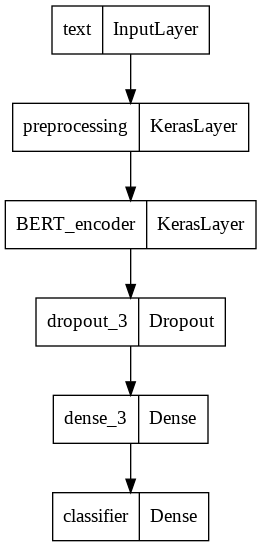

In [271]:
tf.keras.utils.plot_model(classifier_model)

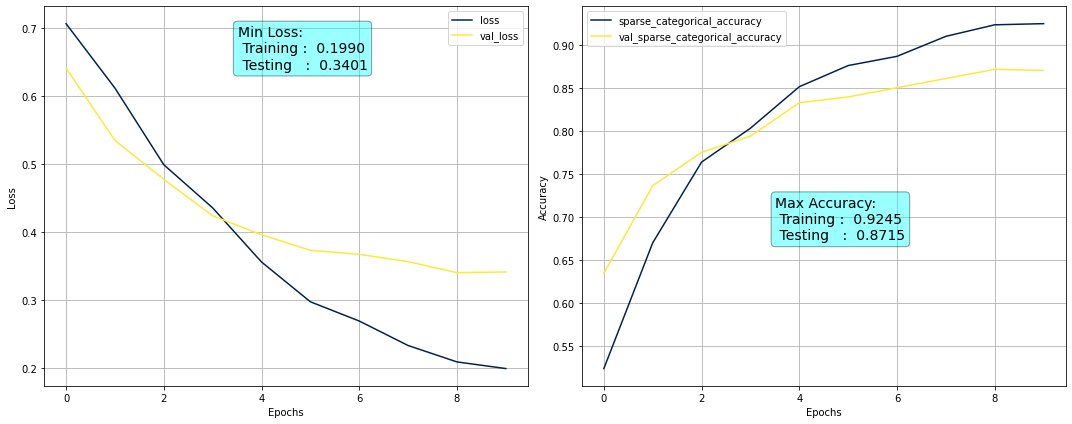

In [254]:
plot_model_performance_graph(loss_df)

In [205]:
y_out = tf.nn.softmax(classifier_model.predict(['it should not be like that its wrong ']))

In [206]:
y_out

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.72542256, 0.27457744]], dtype=float32)>

In [207]:
y_lab = np.argmax(y_out.numpy(),axis = 1)

In [208]:
y_clsses = lb.inverse_transform(y_lab)

In [209]:
y_clsses

array(['criticism'], dtype=object)

In [186]:
submission = pd.DataFrame({
    'id': test_df.iloc[:,0],
    'labels': y_clsses
})

NameError: ignored

In [ ]:
submission.to_csv('submission.csv',index=False)

In [ ]:
# dataset_name = 'tweets'
# saved_model_path = './{}_bert.h5'.format(dataset_name.replace('/', '_'))

# classifier_model.save(saved_model_path, include_optimizer=False)

In [210]:
from visualization_module import  *

In [211]:
y_test = tf.nn.softmax(classifier_model.predict(X_ts))
y_lab = np.argmax(y_test.numpy(),axis = 1)

In [219]:
from sklearn.metrics import confusion_matrix,classification_report

In [226]:
matrix = confusion_matrix(y_ts,y_lab)

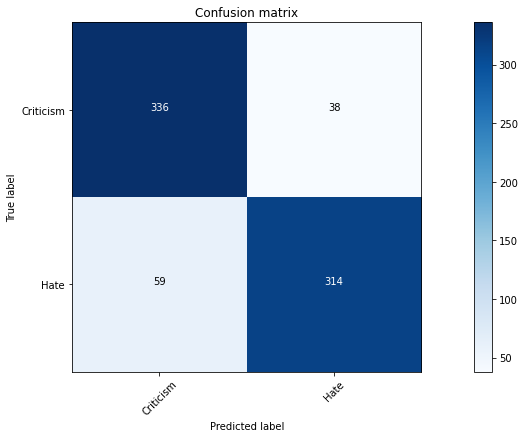

In [227]:
plot_confusion_matrix(matrix,['Criticism' , 'Hate'])

In [228]:
cr = classification_report(y_ts,y_lab)

In [229]:
print(cr)

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       374
           1       0.89      0.84      0.87       373

    accuracy                           0.87       747
   macro avg       0.87      0.87      0.87       747
weighted avg       0.87      0.87      0.87       747

